# Basic example
In this tutorial, it will be shown how to create data set from any source of data. It will also be shown how to create PDF object from a given set of parameters, and how to generate a sample from it and fit it accordingly.


In [1]:
%matplotlib inline
import minkit

## Creating a data set
Data sets can be constructed in many different manners. In this tutorial we will work in the 1-D case, which is also the most common situation. First we need to define the parameter associated to the data. In our case, it will be considered to have values between -5 and +5.
These bounds will define the valid range for the different operations of the PDF involving it. The data set can be easily constructed from a numpy array as follows:

In [2]:
import numpy as np
x = minkit.Parameter('x', bounds=(-5, +5))
raw = np.random.normal(0, 1, 10000)
real_data = minkit.DataSet.from_ndarray(raw, x)

Now the data set contains values following a Gaussian distribution between -5 and +5.

## Creating a PDF
Creating a PDF needs to define previously a set of parameters that rule the behaviour of the function. Let's take a closer look to our data parameter.

In [3]:
print(x)

Parameter(name=x, value=None, bounds=[-5.  5.], error=None, asym_errors=None, constant=False)


As you can see, the created parameter has information about the name, value, bounds, its error, a possible set of asymmetric errors, and whether it must be considered as constant.
We will now create a Gaussian function with two additional parameters: one corresponding to the center, and another for the standard deviation.

In [4]:
c = minkit.Parameter('c', value=0.)
s = minkit.Parameter('s', value=1.)

The PDF is constructed taking the parameters as input arguments, together with a name, that identifies the new PDF object.

In [5]:
g = minkit.Gaussian('g', x, c, s)

## Generating data
Let's now create some data, which can be easily done using the *generate* method of the newly created PDF.

In [6]:
data = g.generate(10000)

This creates a new data set, that in this case only has one associated data parameter. It is easy to plot the output since we can access the data for each data parameter as a dictionary.

In [7]:
data['x']

dtype  = <class 'numpy.float64'>
length = 10000
ndim   = 1
array  = [-0.05658518 -1.04329192  0.48425893 ... -1.67449024 -0.68129712
  1.82177663]

It is important to note that if we are working on a backend involving GPUs, then it is necessary to copy the contents to the CPU before working with numpy or matplotlib. This can be done with the *as_ndarray* method of the returned object, and is a good practice to use it wherever we plan to work with exclusive CPU operations, since changing from one backend to the other will become trivial. In this case, the returned object will be the same as in the previous operation.


In [8]:
data['x'].as_ndarray()

array([-0.05658518, -1.04329192,  0.48425893, ..., -1.67449024,
       -0.68129712,  1.82177663])

## Plotting the results
In order to handle the data correctly when displaying the results, it is recommended to use the *data_plotting_arrays* function. On the other hand, in order to plot the result of the PDF it is necessary to call *pdf_plotting_arrays*, so the PDF is correctly normalized to the data.

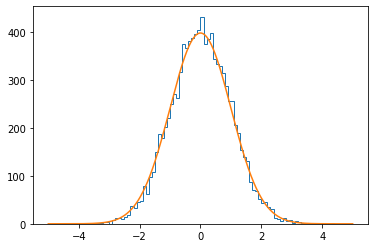

In [9]:
import matplotlib.pyplot as plt
values, edges = minkit.data_plotting_arrays(data, bins=100)
centers = 0.5 * (edges[1:] + edges[:-1])
plt.hist(centers, bins=edges, weights=values, histtype='step') # Plot the data
gf, sf = minkit.pdf_plotting_arrays(g, values, edges)
plt.plot(gf, sf); # Plot the PDF

## Running a simple fit
Let's now fit the data. The process of generating a sample following a distribution from a PDF and fitting it afterwards to the same function is very common in order to do tests of fit estability. In order to do this, first we must initialize a minimizer. These are declared within a context, since some machinery is activated behind your back in order to enable caches for constant PDFs or interpolation maps. It is very important that we do not modify the constness of the values or the data set within this context, since it may lead to an undefined behaviour.

In [10]:
c.bounds = (-1, +1)
s.bounds = (0.1, 5)
with minkit.minimizer('uml', g, data, minimizer='minuit') as minimizer:
    # do not modify the bounds of the parameters in this context
    minimizer.migrad()

FCN = 28062.8310786348 
 TOTAL NCALL = 33 
 NCALLS = 33 
 
 
 EDM = 4.127076795713641e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,c,0.0108685,0.00984336,,,-1,1,No
1,s,0.984347,0.00696097,,,0.1,5,No


The first argument to *minimizer* is the FCN type, which defines the figure of merit to minimize. The second is the PDF and the third is the data set. For this case, the Minuit minimizer is used, so the result of *minimizer* becomes an interface to the *Minuit* class from the *iminuit* package. The minimizer works in such a way that the values of the parameters are automatically set to the result of the minimization process. We can extract the values of the parameters by calling

In [11]:
reg = g.all_real_args.copy()
print(reg)

[Parameter(name=c, value=0.010868451155085168, bounds=[-1.  1.], error=0.009843359887097392, asym_errors=None, constant=False), Parameter(name=s, value=0.984346621804919, bounds=[0.1 5. ], error=0.0069609663561759905, asym_errors=None, constant=False)]


The resulting registry is a new set of parameters that are not linked to those that were minimized (despite they have the same name).